In [30]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

## Load data

In [2]:
mods = [transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,)),    #mean and std of MNIST
        transforms.Lambda(lambda x: torch.flatten(x))]
mods = transforms.Compose(mods)

trainset = datasets.MNIST(root='./data/train', train=True, download=True, transform=mods)
testset = datasets.MNIST(root='./data/test', train=False, download=True, transform=mods)

In [3]:
batch_size = 64

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=1)

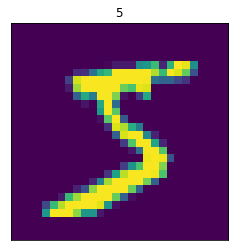

In [4]:
plt.imshow(trainset[0][0].reshape((28, 28)));
plt.title(trainset[0][1]);
plt.xticks([])
plt.yticks([]);

## Prepare a single network module

In [5]:
class SimpleNetwork(torch.nn.Module):
    def __init__(self, inp_size, layers=[100]):
        super().__init__()
        self.layers = []
        
        self.inp = torch.nn.Linear(inp_size, layers[0])
        self.output = torch.nn.Linear(layers[0], 10)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax()
    
    def forward(self, x):
        out = x
        out = self.inp(out)
        out = self.relu(out)
        out = self.output(out)
        return out

In [6]:
def train_net(net, optimizer, epochs, verbose=False):
    for epoch in range(epochs): 
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(trainloader):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            correct += (outputs.argmax(1)==labels).float().sum()
            total += outputs.shape[0]
            running_loss += loss.item()
            if i % 100 == 0:    # print every 2000 mini-batches
                if verbose:
                    print('[%d, %5d] loss: %.3f acc: %.3f%%' %
                          (epoch + 1, i, running_loss / 100, correct/total*100))
                running_loss = 0.0
                correct = 0
                total=0

        correct = 0
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
        print(f"Test acc: {correct/len(testset)*100}")

### Benchmark

In [7]:
net = SimpleNetwork(784)

In [8]:
criterion = torch.nn.CrossEntropyLoss()

In [9]:
%%time
optimizer = torch.optim.Adam(net.parameters(), lr=3e-3)
train_net(net, optimizer, 5)
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)
train_net(net, optimizer, 5)

Test acc: 95.78999999999999
Test acc: 96.67999999999999
Test acc: 97.02
Test acc: 97.21
Test acc: 97.02
Test acc: 97.91
Test acc: 98.07000000000001
Test acc: 98.06
Test acc: 98.16
Test acc: 98.09
CPU times: user 7min 4s, sys: 5.99 s, total: 7min 10s
Wall time: 2min 11s


## Create simple network with insertable weights

In [37]:
flat_parameters = []
for layer in net.parameters():
    flat_parameters.extend(torch.flatten(layer).detach().numpy())
    
flat_parameters = torch.from_numpy(np.array(flat_parameters))

In [56]:
class InsertableNet(SimpleNetwork):
    def __init__(self, weights, inp_size, layers=[100]):
        super().__init__(inp_size, layers)
        with torch.no_grad():
            input_w_size = inp_size*layers[0]
            input_b_size = layers[0]
            
            hidden_w_size = layers[0]*10
            hidden_b_size = 10
            
            inp_weights = weights[:input_w_size].reshape((layers[0], inp_size))
            inp_bias = weights[input_w_size:input_w_size+input_b_size]
            
            output_weights = weights[input_w_size+input_b_size:input_w_size+input_b_size+hidden_w_size].reshape((10, layers[0]))
            output_bias = weights[input_w_size+input_b_size+hidden_w_size:input_w_size+input_b_size+hidden_w_size+hidden_b_size]
            
            self.inp.weight.copy_(inp_weights)
            self.inp.bias.copy_(inp_bias)        
            self.output.weight.copy_(output_weights)
            self.output.bias.copy_(output_bias)        

In [57]:
insert_net = InsertableNet(flat_parameters, 784)

In [58]:
correct = 0
for data in testloader:
    images, labels = data
    outputs = insert_net(images)
    _, predicted = torch.max(outputs.data, 1)
    correct += (predicted == labels).sum().item()
print(f"Test acc: {correct/len(testset)*100}")

Test acc: 98.09


### Create hypernet structure

In [ ]:
class Hypernetwork(torch.nn.Module):
    def __init__(self, inp_size=784, mask_size=20):
        